In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
image_dir = Path('/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images')

In [4]:
filepath = list(image_dir.glob(r'**/*.jpg'))
label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))

In [5]:
filepath = pd.Series(filepath, name = 'Filepath').astype(str)
label = pd.Series(label, name = 'Label')
image_df = pd.concat([filepath, label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
image_df.head()

,Filepath,Label
0,/Users/davemag9/Desktop/Diploma/archive1/India...,imarti
1,/Users/davemag9/Desktop/Diploma/archive1/India...,chikki
2,/Users/davemag9/Desktop/Diploma/archive1/India...,dal_makhani
3,/Users/davemag9/Desktop/Diploma/archive1/India...,sutar_feni
4,/Users/davemag9/Desktop/Diploma/archive1/India...,bhatura


In [6]:
len(image_df['Label'].unique())

80

In [7]:
image_df.shape

(4000, 2)

In [8]:
le = LabelEncoder()
image_df['Label'] = le.fit_transform(image_df['Label'])
image_df['Label'].value_counts()

Label
36    50
23    50
24    50
11    50
7     50
      ..
8     50
28    50
45    50
29    50
67    50
Name: count, Length: 80, dtype: int64

In [9]:
train_df, test_df = train_test_split(image_df, test_size = 0.30, shuffle = True, random_state = 1)

In [10]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [11]:
train_df['Label'] = train_df['Label'].astype(str)
test_df['Label'] = test_df['Label'].astype(str)


In [12]:
train_image = train_gen.flow_from_dataframe(dataframe = train_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (224,224),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = True,
                                           seed = 42,
                                           subset = 'training')
val_image = train_gen.flow_from_dataframe(dataframe = train_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (224,224),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = True,
                                           seed = 42,
                                           subset = 'validation')
test_image = test_gen.flow_from_dataframe(dataframe = test_df,
                                           x_col = 'Filepath',
                                           y_col = 'Label',
                                           target_size = (224,224),
                                           batch_size = 32,
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle = False)

Found 2240 validated image filenames belonging to 80 classes.
Found 560 validated image filenames belonging to 80 classes.
Found 1200 validated image filenames belonging to 80 classes.


In [13]:
inputs = tf.keras.Input(shape = (224,224,3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size =(3,3), activation = 'relu' )(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size =(3,3), activation = 'relu' )(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'linear')(x)



In [14]:
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam',
             loss = 'mse',
             metrics = ['accuracy'])

In [15]:
history  = model.fit(train_image,
                    validation_data = val_image,
                    epochs = 5,
                    callbacks = [tf.keras.callbacks.EarlyStopping(
                    monitor = 'val_loss',
                    patience = 5,
                    restore_best_weights = True)])

Epoch 1/5


/Users/davemag9/Desktop/Diploma/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.9875 - loss: 0.0128 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.9875 - loss: 0.0123 - val_accuracy: 0.9875 - val_loss: 0.0123


In [16]:
result = model.evaluate(test_image, verbose = 0)
print('Test Loss : {:.3f}'.format(result[0]))
print('Test Accuracy : {:.3f}%'.format(result[1]*100))

/Users/davemag9/Desktop/Diploma/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss : 0.012
Test Accuracy : 98.750%


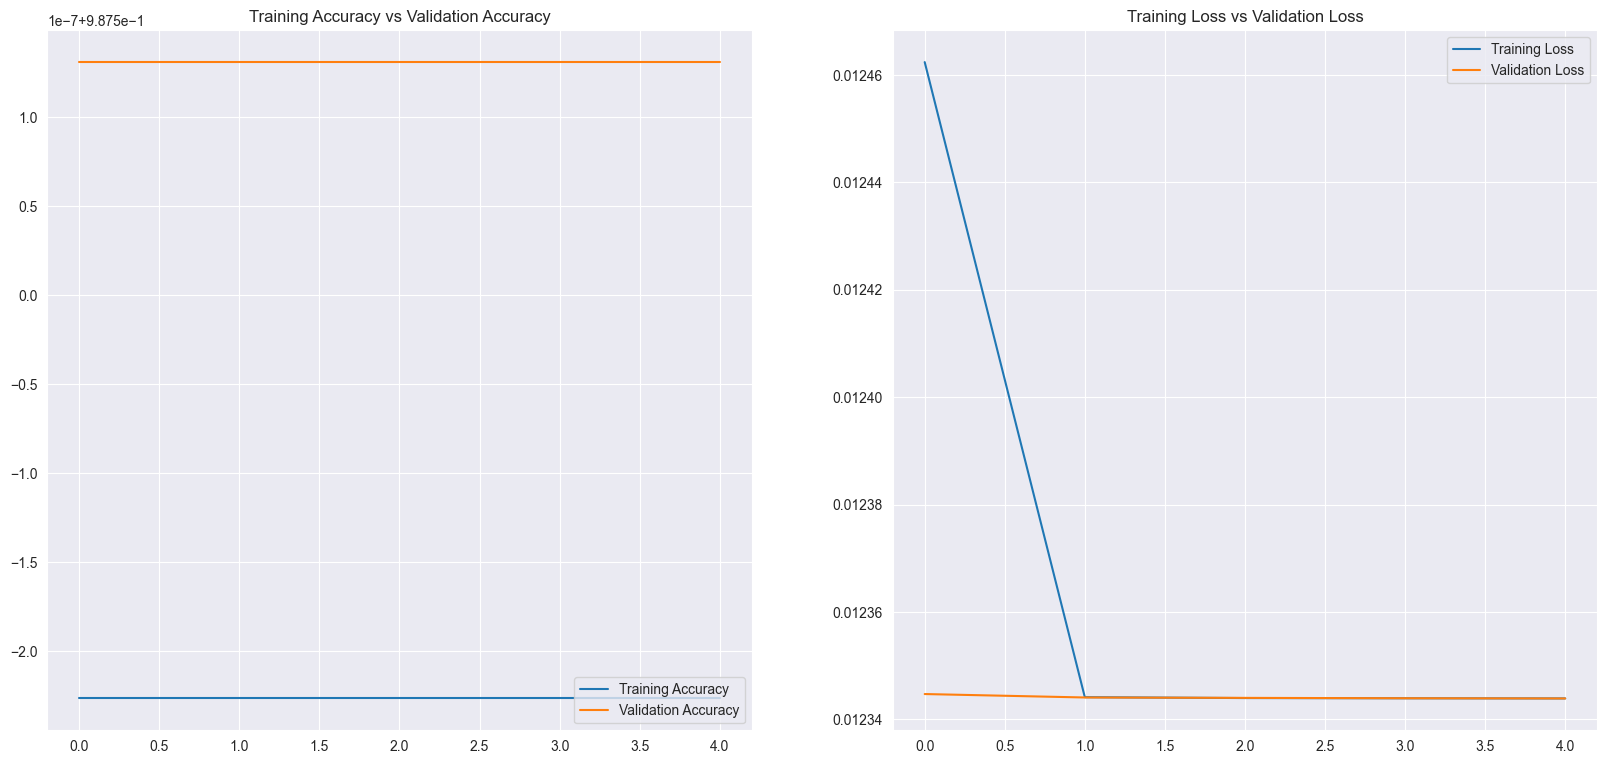

In [21]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(range(5),history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(5), history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend(loc = 'lower right')
plt.subplot(2,2,2)
plt.plot(range(5),history.history['loss'], label = 'Training Loss')
plt.plot(range(5), history.history['val_loss'], label = 'Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend(loc = 'upper right')
plt.show()

In [18]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels from test generator
y_true = test_image.classes

# Predict probabilities
y_pred_probs = model.predict(test_image)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels
class_labels = list(test_image.class_indices.keys())

# Generate and print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
              precision    recall  f1-score   support

           0       0.01      1.00      0.02        15
           1       0.00      0.00      0.00        23
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00        16
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        16
          14       0.00      0.00      0.00        14
          15       0.00      0.00      0.00        15
          16       0.00      0.00      0.00        13
          17       0.00      0.00      0.00        10
          18       0.00      0.00      0.00        11
          19       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        15
          20       0.00      0.00      0.00        20
          21       0.00      0.00      0.00        15
          22       0.00      0.00      0.00        12
          23       0.00      0.00      0.

/Users/davemag9/Desktop/Diploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/davemag9/Desktop/Diploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/davemag9/Desktop/Diploma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap